# Exploratory data anaylsis

## Look at data and clean up one year

In [8]:
import pandas as pd
df = pd.read_excel("../notebooks/Historical Station Counts by State 2007-2021.xlsx", sheet_name='2020', skiprows=1)
df

,State,Biodiesel,CNG,E85,Electrica,Hydrogenb,LNG,Propanec,Totald
0,NaN,NaN,NaN,NaN,(stations / charging outlets,(retail / non-retail / total),NaN,(primary / secondary / total),NaN
1,NaN,NaN,NaN,NaN,Level 1 / Level 2 / DC Fast),NaN,NaN,NaN,NaN
2,Alabama,10.0,30.0,29.0,223 / 596,0 / 0 / 0,2.0,24 / 45 / 69,736.0
3,NaN,NaN,NaN,NaN,56 / 449 / 91,NaN,NaN,NaN,NaN
4,Alaska,0.0,1.0,0.0,25 / 45,0 / 0 / 0,0.0,1 / 2 / 3,49.0
...,...,...,...,...,...,...,...,...,...
107,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,(a) Includes legacy chargers but does not incl...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,(b) Primary propane stations offer vehicle-spe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,(c) Retail hydrogen stations accept payment at...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    df_cleaned = df.dropna(how="all")
    df_cleaned = df_cleaned.rename(columns={"Totald" : "Total"})
    df_cleaned = df_cleaned[["State", "Total"]]
    df_cleaned = df_cleaned.dropna()
    df_cleaned['State'] = df_cleaned['State'].astype('category')
    return df_cleaned

df_total = pd.DataFrame()
for n in range(2007, 2022, 1):
    df = pd.read_excel("../notebooks/Historical Station Counts by State 2007-2021.xlsx", sheet_name=str(n), skiprows=1)
    df_cleaned = clean_data(df)
    df_cleaned["Year"] = n
    df_total = pd.concat([df_total, df_cleaned])

Get some general info about the data

In [10]:
df_total.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 780 entries, 2 to 104
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   State   780 non-null    category
 1   Total   780 non-null    float64 
 2   Year    780 non-null    int64   
dtypes: category(1), float64(1), int64(1)
memory usage: 21.5 KB


In [11]:
df_total.describe(include='all')

,State,Total,Year
count,780,780.000000,780.000000
unique,52,NaN,NaN
top,Alabama,NaN,NaN
freq,15,NaN,NaN
mean,NaN,1802.579487,2014.000000
std,NaN,8917.620078,4.323266
min,NaN,6.000000,2007.000000
25%,NaN,112.000000,2010.000000
50%,NaN,294.500000,2014.000000
75%,NaN,969.250000,2018.000000


Check how many missing values we have

In [12]:
df_total.isna().mean()

State    0.0
Total    0.0
Year     0.0
dtype: float64

## Training a regression model on all data

In [13]:
from mlwrap.algorithms import get_sklearn_linear_model
from mlwrap.config import MLConfig, TrainingResults
from mlwrap.enums import ProblemType
from mlwrap import runners, scores

df_train = df_total
problem_type = ProblemType.Regression
config = MLConfig(
                problem_type=problem_type,
                model_feature_id="Total",
                algorithm=get_sklearn_linear_model(problem_type)
            )
results = runners.train(config, df_train)
scores.print_scores(results.scores)

,value
iterations,[1]
total_row_count,[780]
active_feature_count,[0]
inactive_feature_count,[0]
mean_abs_error,[2135.573194701547]
median_abs_error,[1219.1665344076357]
norm_mean_abs_error,[7.342613158699871]
norm_median_abs_error,[3.175207212114723]
mean_squared_error,[38106248.46253327]


Scores are better for states with lower counts if we train a model per state.

It is also cleaner if we just use the Total value for all states.

/var/folders/vc/2v8cvy_11715btkp90f5tzyw0000gn/T/ipykernel_82508/3986169313.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_train_total = df_total[df['State'] == 'Total']


<AxesSubplot: xlabel='Year'>

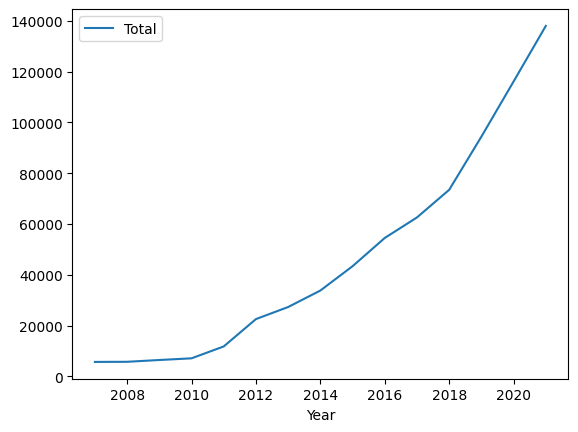

In [63]:
df_train_total = df_total[df['State'] == 'Total']
df_train_total = df_train_total.drop('State', axis=1)
df_train_total = df_train_total.reset_index(drop=True)
df_train_total.plot(x="Year",y="Total")

In [64]:
df_train_total

,Total,Year
0,5692.0,2007
1,5742.0,2008
2,6449.0,2009
3,7111.0,2010
4,11788.0,2011
5,22561.0,2012
6,27314.0,2013
7,33805.0,2014
8,43384.0,2015
9,54517.0,2016


In [65]:
results_total = runners.train(config, df_train_total)
scores.print_scores(results_total.scores)

,value
iterations,[1]
total_row_count,[15]
active_feature_count,[0]
inactive_feature_count,[0]
mean_abs_error,[13311.892490546432]
median_abs_error,[11999.722852512365]
norm_mean_abs_error,[1.7542710574266558]
norm_median_abs_error,[0.3549688759802503]
mean_squared_error,[308126963.6320984]


## Make predictions

Use a slight overlap with the input data to see how the predictions would match the training set.

In [66]:
years = [y for y in range(2015, 2031)]
df_test = pd.DataFrame({"Year" : years})
predictions = results_total.model.predict(df_test)
predictions


array([ 55525.88573744,  65247.04862237,  74968.21150729,  84689.37439222,
        94410.53727715, 104131.70016207, 113852.863047  , 123574.02593193,
       133295.18881685, 143016.35170178, 152737.51458671, 162458.67747164,
       172179.84035657, 181901.00324149, 191622.16612642, 201343.32901135])

In [67]:
df_test['Prediction'] = predictions.tolist()
df_test

,Year,Prediction
0,2015,55525.885737
1,2016,65247.048622
2,2017,74968.211507
3,2018,84689.374392
4,2019,94410.537277
5,2020,104131.700162
6,2021,113852.863047
7,2022,123574.025932
8,2023,133295.188817
9,2024,143016.351702


Plot the predictions against the training set

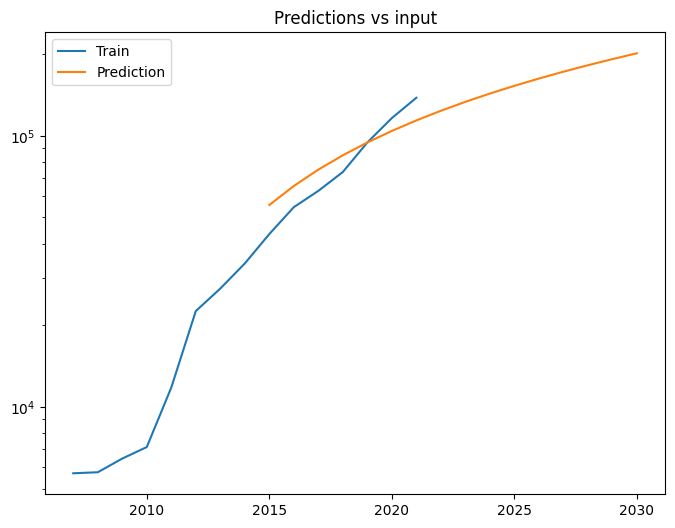

In [68]:
import matplotlib.pyplot as plt
def plot_predictions(train, test):
    plt.figure(figsize=(8,6))
    plt.plot(train.Year, train.Total, label='Train')
    plt.plot(test.Year, test.Prediction, label='Prediction')
    # plt.xticks(df_train_total["Year"], df_train_total["Year"], rotation='vertical')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.title("Predictions vs input")
    plt.show()
plot_predictions(df_train_total, df_test)

The linear model fit is... well... a straight line. Good start but this could likely be improved by adding a window function and then making extrapolated predictions by recursively folding model predictions (i.e. walk-forward).

## Try an auto-regressive model


In [69]:
from statsmodels.tsa.ar_model import AutoReg
model_ag = AutoReg(endog = df_train_total["Total"], \
                   lags = 1, \
                   trend='c', \
                   seasonal = False, \
                   exog = None, \
                   hold_back = None, \
                   period = None, \
                   missing = 'none')
fit_ag = model_ag.fit()
print("Coefficients:\n%s" % fit_ag.params)

Coefficients:
const       1677.889938
Total.L1       1.192638
dtype: float64


In [70]:
df_train_total['Year'].iloc[-1]
years = [y for y in range(df_train_total.Year.iloc[-1]+1, df_train_total.Year.iloc[-1] + 22)]
years

predictions = fit_ag.predict(start=len(df_train_total), \
                             end=len(df_train_total)+20, \
                             dynamic=False)
df_test_ar = pd.DataFrame({"Year" : years, "Prediction" : predictions.tolist()})
df_test_ar

,Year,Prediction
0,2022,1.662857e+05
1,2023,1.999965e+05
2,2024,2.402012e+05
3,2025,2.881509e+05
4,2026,3.453375e+05
5,2027,4.135404e+05
6,2028,4.948817e+05
7,2029,5.918924e+05
8,2030,7.075910e+05
9,2031,8.455775e+05


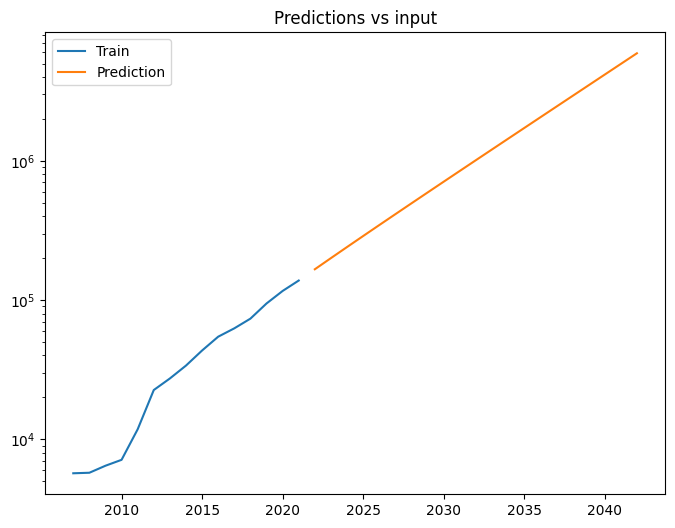

In [71]:
plot_predictions(df_train_total, df_test_ar)

Make a prediction using datetime stamps rather than array indices as that is what we would want to use in a predict API

In [73]:
def get_training_data_with_datetime_index(df) -> pd.DataFrame:
    df = df.copy()
    df.Year = pd.to_datetime(df.Year, format="%Y")
    df.reset_index(drop=True)
    df = df.set_index('Year')
    return df
df_dt = get_training_data_with_datetime_index(df_train_total)
df_dt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15 entries, 2007-01-01 to 2021-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Total   15 non-null     float64
dtypes: float64(1)
memory usage: 240.0 bytes


In [82]:
model_ag = AutoReg(endog = df_dt, \
                   lags = 1, \
                   trend='c', \
                   seasonal = False, \
                   exog = None, \
                   hold_back = None, \
                   period = None, \
                   missing = 'none')
fit_ag = model_ag.fit()
print("Coefficients:\n%s" % fit_ag.params)

Coefficients:
const       1677.889938
Total.L1       1.192638
dtype: float64


/Users/rossparkin/Projects/ak/mlops-intro/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)


In [83]:
from datetime import datetime
predictions = fit_ag.predict(start=datetime(2016, 1, 1), \
                             end=datetime(2040, 1, 1), \
                             dynamic=False)
df_pred = pd.DataFrame({"Year" : predictions.index, "Prediction" : predictions})
df_pred

/Users/rossparkin/Projects/ak/mlops-intro/.venv/lib/python3.9/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


,Year,Prediction
2016-01-01,2016-01-01,5.341928e+04
2017-01-01,2017-01-01,6.669691e+04
2018-01-01,2018-01-01,7.632746e+04
2019-01-01,2019-01-01,8.930694e+04
2020-01-01,2020-01-01,1.142748e+05
2021-01-01,2021-01-01,1.401980e+05
2022-01-01,2022-01-01,1.662857e+05
2023-01-01,2023-01-01,1.999965e+05
2024-01-01,2024-01-01,2.402012e+05
2025-01-01,2025-01-01,2.881509e+05


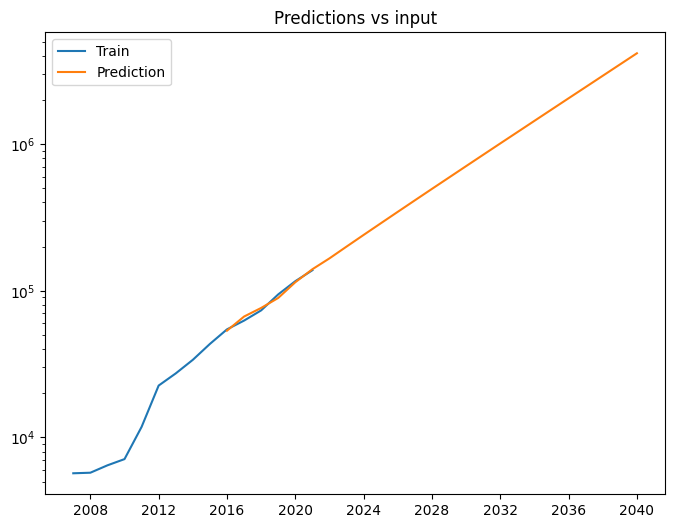

In [84]:
df_tt_dt = df_train_total.copy()
df_tt_dt.Year = pd.to_datetime(df_tt_dt.Year, format="%Y")
plot_predictions(df_tt_dt, df_pred)

How do we then make a single prediction

In [85]:
predictions = fit_ag.predict(start=datetime(2020, 1, 1), \
                             end=datetime(2020, 1, 1), \
                             dynamic=False)
predictions.values[0]

114274.80471752574

For comparison, get some scores for the model using a test set

In [87]:
def print_scores(train, pred):
    y_test = train[(train.Year > 2016) & (train.Year < 2021)].Total.values
    y_pred = pred[(pred.Year > datetime(2016,1,1)) & (pred.Year < datetime(2021,1,1))].Prediction.values
    scores_ag = scores.get_scores(ProblemType.Regression, y_test, y_pred)
    return scores.print_scores(scores_ag)
print_scores(df_train_total, df_pred)

,value
mean_abs_error,[3482.9084449110196]
median_abs_error,[3478.6876442239445]
norm_mean_abs_error,[0.04364178782334191]
norm_median_abs_error,[0.046437178760622144]
mean_squared_error,[13632369.672535392]


The scores are considerably better for an auto-regression model compared to a linear regression

## ARIMA model

In [88]:
from statsmodels.tsa.arima.model import ARIMA
df_dt = get_training_data_with_datetime_index(df_train_total)
model_arima = ARIMA(endog = df_dt, \
                   order = (1, 1, 1))
fit_arima = model_arima.fit()
print("Coefficients:\n%s" % fit_arima.params)

Coefficients:
ar.L1     1.000000e+00
ma.L1     5.648804e-02
sigma2    1.806527e+07
dtype: float64


/Users/rossparkin/Projects/ak/mlops-intro/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/rossparkin/Projects/ak/mlops-intro/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/rossparkin/Projects/ak/mlops-intro/.venv/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  self._init_dates(dates, freq)
/Users/rossparkin/Projects/ak/mlops-intro/.venv/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive

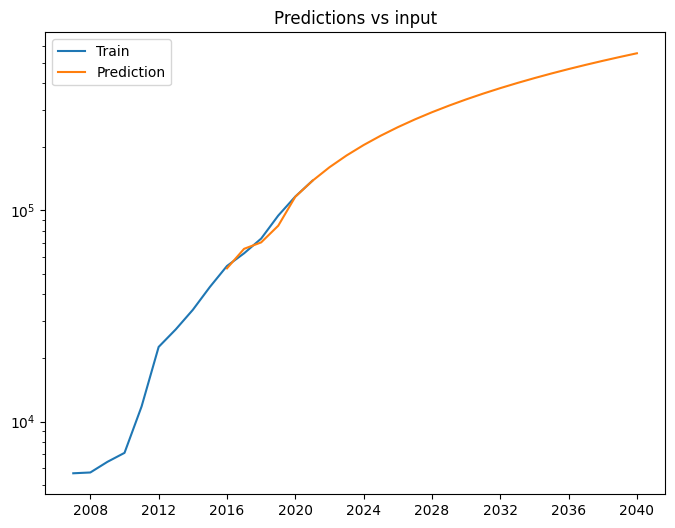

In [89]:
predictions = fit_arima.predict(start=datetime(2016, 1, 1), \
                             end=datetime(2040, 1, 1), \
                             dynamic=False)
df_pred = pd.DataFrame({"Year" : predictions.index, "Prediction" : predictions})
df_tt_dt = df_train_total.copy()
df_tt_dt.Year = pd.to_datetime(df_tt_dt.Year, format="%Y")
plot_predictions(df_tt_dt, df_pred)

In [90]:
print_scores(df_train_total, df_pred)

,value
mean_abs_error,[4061.88812567513]
median_abs_error,[3060.735322959321]
norm_mean_abs_error,[0.04937769805052125]
norm_median_abs_error,[0.04536772210079354]
mean_squared_error,[29121903.3345826]


Surprisingly, the errors are slightly larger for ARIMA compared to a basic AR. That said, ARIMA and AR are much better than a basic linear regression.